In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim

In [2]:
# you can set your hyper-parameter here
# 设置一些参数

# epoch表示的是
epochs = 3

# 设置batch_size，也就是一个batch的大小
batch_size = 64

# 学习率,设置0.01是0.97，0.001是0.879，0.1的是0.9875，
lr = 0.11

# 动量？？？
momentum = 0.5

# 设置log_interval=10，每隔10个batch会输出，而batch_size=64,所以每隔640个数据输出一次
log_interval = 10

In [3]:
# dataset init,注意这里的Normalize，也就是说这里归一化了数据（transforms.Normalize...,感觉重复了，可以提取出来）

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

train_dataset = torchvision.datasets.MNIST('./data/', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('./data/', train=False, download=True, transform=transform)

# why *—loader？感觉像是要用batch_size,将之前的tensor<(1,28,28),label>的数据转换为tensor<(batch_size,1,28,28),label>的数据
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)


# # # what is train_loader?
# print(train_dataset)
# print(train_loader)


# # for data, label in train_dataset:
# for data, label in train_loader:
#     print(data.shape)#train_dataset的torch.Size([1, 28, 28])，train_loader的torch.Size([64, 1, 28, 28])
#     print("===============")
#     print(label)
# #     print(label.shape)# torch.Size([64])
#     print("11111111111111111111")

# 后面数据可视化的next(iter(train_loader))?
# iter()函数和next()函数是python的基本语法，
# next()函数作用于可迭代对象（iterator）,可不断调用，用于返回可迭代对象的下一个数据
# 而iter()函数，是将一些不是iteratro的迭代对象转化为迭代对象，然后使用next函数，比如list,dict等，

# list = [1,2,3,4,5]
# # next(list)   # 报错 TypeError: 'list' object is not an iterator
# next(iter(list))  # <== 1
# next(iter(list))  # <== 2
# next(iter(list))  # <== 3

# 当然也有另一个函数enumerate函数。也可，不过是增强的iter()
# enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标

# 这个可以加一个索引，比较好通过索引找
# examples = enumerate(test_loader)
# batch_idx, (example_data, example_targets) = next(examples)
# batch_idx, (example_data, example_targets) = next(examples)
# print(batch_idx)
# print(example_data.shape)


torch.Size([64, 1, 28, 28])
tensor([1, 8, 5, 9, 0, 1, 2, 2, 9, 6, 1, 7, 3, 1, 3, 9, 6, 0, 3, 6, 4, 2, 8, 7,
        0, 0, 0, 3, 7, 4, 6, 4, 5, 6, 4, 4, 9, 7, 8, 5, 2, 3, 8, 3, 2, 6, 0, 9,
        7, 6, 1, 0, 3, 6, 8, 7, 6, 1, 9, 3, 1, 0, 9, 9])


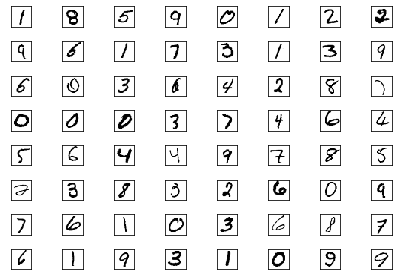

In [4]:
# data visualization，数据可视化
# 这里输出的是一个batch_size（也就是64张图片的量），所以只有一次next。
sample, label = next(iter(train_loader))
print(sample.shape) # one training data batch is a  tensor of shape [64, 1, 28, 28]
print(label)

# 绘制多个图使用subplots，横8，纵8
fig, ax = plt.subplots(nrows=8,ncols=8,sharex=True,sharey=True)
ax = ax.flatten()

for i in range(64):
    img = sample[i].numpy().reshape(28,28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [5]:
# Model,定义网络结构,这里使用LeNet模型 
# input->卷积1层->激活函数->池化1层->卷积2层->激活函数->池化2层->几个full connection层->output
class Model(torch.nn.Module):

    # 看别人的一般都是在init中初始化某些变量到self中（比如self.fun = ...），然后在前向传播过程中，直接通过self.fun去调用函数。
    # 比如：CONV2D函数表示二维卷积，返回值为一个函数，所以就可以self.conv1=nn.Conv2d(参数...);然后在forward中使用self.conv1.
    def __init__(self):
        super(Model, self).__init__()
        """
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
            - in_channels：输入channel数
            - out_channels：输出channel数
            - kernel_size：卷积核的大小，一般使用3比较多，配合上stride=1和padding=1可以保证卷积前后尺寸不变
        
        torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
            - in_features：输入特征维度
            - out_features：输出特征维度
        """
        # 定义网络层用到的layer层函数
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)    # 这里也可以用平均池化nn.AvgPool2d      
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
   
    # 前向传播过程,最后返回的是最终输出的预测label
    # 额。。。
    '''
    输入：
        self:可以看作java里面的this，可以调用定义的net结构
        x:表示输入的特征，tensor类型，这里tensor是tensor<batch_size,channel,height,weight>的4维。
    
    输出：
        output：输出值，本案例不是one-hot类型，而是scalar类型，但是由于每次训练的都是一个batch，所以输出也是tensor(tensor<batch_size>)，一维的tensor类型
    '''
    def forward(self, x):
        # print(self)# self 是啥？他自己。
        """
        please fill your code here
        """
        x = self.pool(F.relu(self.conv1(x)))
        
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape) # <==输出一下看下面的view的参数是啥，torch.Size([64, 16, 5, 5])
        x = x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x = self.fc3(x)
        # print(x.shape)# 最终输出的是啥形状torch.Size([64,10])，可以
        return x

In [6]:
# model init
# 定义模型
model = Model()
# print(model)
"""
please fill your code here to determine the loss and optimizer
Loss = 
optimizer = 
"""

# 作为分类问题，一般使用交叉熵的loss函数。查一下吧。
Loss = nn.CrossEntropyLoss()


# 作为优化器，使用Adam优化器
# optimizer = optim.Adam(params=model.parameters(),lr=0.01)
# 或者使用SGD优化
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=lr,momentum=momentum)

In [7]:
# training
batch_done = 0
logs = []
# 对每一个epoch都遍历。
for i in range(epochs):
    for data,label in train_loader:
        
        # 将梯度的存储tensor清空
        optimizer.zero_grad()
        
        # 通过输入data数据放入model中，然后给出预测值output，然后比较output和label的loss函数，然后梯度下降
        output = model(data);
        # print(output)
        loss=Loss(output,label)
        loss.backward()
        optimizer.step()
        
        # 标准化输出
        batch_done += 1
        if batch_done % log_interval == 0:
            logs.append([batch_done,loss.item()])
            print('Epoch {}: {}/{} loss:{}'.format(i, (batch_done)%len(train_loader), len(train_loader), loss.item()))

print("训练完成。。。。。")
    
    


Epoch 0: 10/938 loss:2.1514039039611816
Epoch 0: 20/938 loss:2.2529430389404297
Epoch 0: 30/938 loss:1.3139944076538086
Epoch 0: 40/938 loss:1.308555006980896
Epoch 0: 50/938 loss:0.8053418397903442
Epoch 0: 60/938 loss:0.3534198999404907
Epoch 0: 70/938 loss:0.426094651222229
Epoch 0: 80/938 loss:0.3780660629272461
Epoch 0: 90/938 loss:0.4046509563922882
Epoch 0: 100/938 loss:0.5896574854850769
Epoch 0: 110/938 loss:0.27282607555389404
Epoch 0: 120/938 loss:0.1662033051252365
Epoch 0: 130/938 loss:0.057030316442251205
Epoch 0: 140/938 loss:0.2707075774669647
Epoch 0: 150/938 loss:0.17725910246372223
Epoch 0: 160/938 loss:0.1866069883108139
Epoch 0: 170/938 loss:0.1608787477016449
Epoch 0: 180/938 loss:0.20869241654872894
Epoch 0: 190/938 loss:0.1740817278623581
Epoch 0: 200/938 loss:0.30045074224472046
Epoch 0: 210/938 loss:0.1468886286020279
Epoch 0: 220/938 loss:0.25338542461395264
Epoch 0: 230/938 loss:0.3664698302745819
Epoch 0: 240/938 loss:0.19623896479606628
Epoch 0: 250/938 lo

Epoch 2: 104/938 loss:0.041246797889471054
Epoch 2: 114/938 loss:0.035955119878053665
Epoch 2: 124/938 loss:0.01288757473230362
Epoch 2: 134/938 loss:0.11007031798362732
Epoch 2: 144/938 loss:0.1481642872095108
Epoch 2: 154/938 loss:0.03312733769416809
Epoch 2: 164/938 loss:0.032225269824266434
Epoch 2: 174/938 loss:0.012864451855421066
Epoch 2: 184/938 loss:0.005461498629301786
Epoch 2: 194/938 loss:0.0094498535618186
Epoch 2: 204/938 loss:0.01766818016767502
Epoch 2: 214/938 loss:0.0032813057769089937
Epoch 2: 224/938 loss:0.032763347029685974
Epoch 2: 234/938 loss:0.005199408158659935
Epoch 2: 244/938 loss:0.008888580836355686
Epoch 2: 254/938 loss:0.12314477562904358
Epoch 2: 264/938 loss:0.02459227852523327
Epoch 2: 274/938 loss:0.019627222791314125
Epoch 2: 284/938 loss:0.09503259509801865
Epoch 2: 294/938 loss:0.03956085816025734
Epoch 2: 304/938 loss:0.03303041681647301
Epoch 2: 314/938 loss:0.008092585951089859
Epoch 2: 324/938 loss:0.06904703378677368
Epoch 2: 334/938 loss:0.

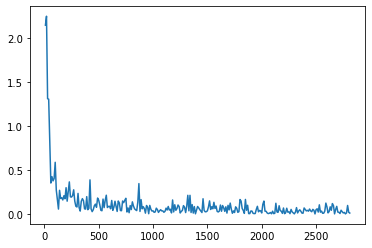

In [8]:
# # loss curve visualization，损失曲线可视化
# print(logs.shape)# (281, 2)
# print(logs)

logs = np.array(logs)
plt.plot(logs[:,0],logs[:,1])

In [9]:
# # evaluation，评估
model.eval()
correct = 0
for data, label in test_loader:
    output = model(data)
    _,pred = torch.max(output, dim=1)
    correct += float(torch.sum(pred == label))

print('test_acc:{}'.format(correct/len(test_dataset)))
    

test_acc:0.9862
